<a href="https://colab.research.google.com/github/IFuentesSR/Soil_moisture/blob/main/PDSI_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=jv5GgdKiR_ZqFsAe_LT-BLYSbtOWWWile8g8Jq5v2Is&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjCZa3bJ_l-Fq8S3Z20eF2recQlVxeYewkVbQAduo2C9ht2N2EaXBE

Successfully saved authorization token.


In [ ]:
import folium
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print(folium.__version__)

0.8.3


In [ ]:
def get_pdsi(img):
    props = img.propertyNames()
    return img.select('pdsi').multiply(0.01).copyProperties(img, props)


def sample_geo(geo):
    def wrap(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        drought = img.reduceRegion('first', geo, 10000).values().get(0)
        return ee.Feature(None, {'date':date, 'drought':drought})
    return wrap

In [ ]:
geo = ee.Geometry.Point([149.57255453521313, -30.255089976050286])
coll = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
coll = coll.filterDate('2016-01-01', '2021-06-01')
coll = coll.map(get_pdsi)

In [ ]:
img = coll.first()
mapidCon = ee.Image(img).getMapId({'min': -5, 'max': 5, 'palette': 'FF0000, FFFFFF, 0000FF', 'opacity':0.4})
centroid = geo.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='satellite',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='SPEI',
    ).add_to(map)
map.add_child(folium.LayerControl())
map


In [ ]:
drought = coll.map(sample_geo(geo)).getInfo()
ixs = [n['properties']['drought'] for n in drought['features']]
time = [pd.to_datetime(n['properties']['date'], format='%Y-%m-%d') for n in drought['features']]

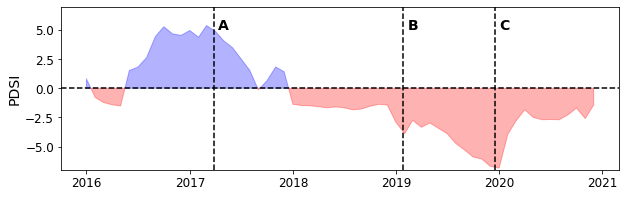

In [ ]:
df = pd.DataFrame(data={'pdsi':ixs, 'date':time})
d = np.zeros(len(ixs))

fig = plt.figure(figsize=(10, 3))
plt.fill_between(time, d, ixs, where=df['pdsi']>=d, interpolate=True, color='blue', alpha=0.3, label='PDSI')
plt.fill_between(time, d, ixs, where=df['pdsi']<=d, interpolate=True, color='red', alpha=0.3)
plt.ylabel('PDSI', fontsize=14)
plt.axhline(0, color='k', ls='--')
plt.axvline(pd.to_datetime('2017-03-26'), color='k', ls='--')
plt.axvline(pd.to_datetime('2019-01-27'), color='k', ls='--')
plt.axvline(pd.to_datetime('2019-12-17'), color='k', ls='--')
plt.ylim(-7, 7)
plt.text(pd.to_datetime('2017-04-10'), 5, 'A', weight='bold', fontsize=14)
plt.text(pd.to_datetime('2019-02-10'), 5, 'B', weight='bold', fontsize=14)
plt.text(pd.to_datetime('2019-12-31'), 5, 'C', weight='bold', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
fig.show()